# 🔹Atividade Final


## **Projeto** Integrado de Classificação Supervisionada com scikit-learn

### 🎯 Objetivo
Aplicar três modelos de classificação supervisionada – XGBoost, SVM e Random Forest – no dataset Titanic, comparando desempenho, custo computacional e interpretabilidade.

## 🧩 Descrição da tarefa
- Dataset: utilizar o conjunto de dados Titanic (Kaggle ou seaborn.load_dataset("titanic")).

- Variável target: Survived (0 = não sobreviveu, 1 = sobreviveu).

- Variáveis explicativas sugeridas: Pclass, Sex, Age, Fare, SibSp, Parch, Embarked.

- Pré-processamento:

  Tratar valores ausentes (ex.: Age, Embarked).

  Aplicar StandardScaler para variáveis numéricas (Age, Fare).

  Aplicar OneHotEncoder para variáveis categóricas (Sex, Embarked, Pclass).

- Modelagem:

  Treinar e comparar XGBoost, SVM (RBF) e Random Forest.

  Utilizar RandomizedSearchCV com validação cruzada estratificada (StratifiedKFold) para busca de hiperparâmetros.

- Métricas:

  Principal: ROC-AUC.

  Secundárias: Acurácia, F1-score e matriz de confusão.

  Plotar curvas ROC e Precision-Recall para cada modelo.

- Resultados esperados:

  Tabela comparativa com as métricas dos três modelos.

- Discussão:

  Qual modelo apresentou melhor desempenho?

  Algum modelo mostrou sinais de overfitting?

  Quais foram as dificuldades no pré-processamento?

# Importação das Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from math import remainder
from pandas.core.tools import numeric
from pandas.core.tools import numeric
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    auc
)

# Carga e Preparação dos Dados

- Carregar o dataset
- Definição das Features e Target
- Divisão Estratificada (Train/Test Split)


In [ ]:

ds = sns.load_dataset("titanic")


features= ['pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'embarked']
df = ds[features]

target = 'survived'

numeric_features = ['age', 'fare', 'sibsp', 'parch']
categorical_features = ['pclass', 'sex', 'embarked']

#Divisão Trainamento e Teste

x= ds[features]
y= ds[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("Quantidade de Treino:", x_train.shape[0])
print("Quantidade de Teste:", x_test.shape[0])


Quantidade de Treino: 712
Quantidade de Teste: 179


# Pré-processamento

- Pipeline para Features Numéricas
- Pipeline para Features Categóricas
- Combinador

In [ ]:
# Pipeline para Features Numéricas

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para Features Categóricas

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder= 'passthrough'
)

# Definição dos Modelos

- Estratégia de Validação Cruzada
- Definição dos Modelos e Grades de Hiperparâmetros


In [ ]:
# Estratégia de Validação Cruzada

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definição dos Modelos e Grades de Hiperparâmetros

#  SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_param_grid = {
    'model__C': [0.1,1,10,100],
    'model__gamma': [1,0.1,0.01,0.001, 'scale','auto'],
    'model__class_weight': ['balanced', None]
}

# XGBoost
xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)
xgb_param_grid = {
    "model__n_estimators": [50, 100, 150, 200],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [2, 3, 4, 5],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.5, 0.7, 1.0]
}

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__bootstrap": [True, False]
}

models_to_run = [
    ("SVM", svm_model, svm_param_grid),
    ("XGBoost", xgb_model, xgb_param_grid),
    ("Random Forest", rf_model, rf_param_grid)
]

best_models ={}
results = {}

In [ ]:
for name, model, params in models_to_run:
  print("---- Iniciando Otimização para o Modelo: ", name, " ----")
  start_time = time.time()



  full_pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('model', model)
  ])

  random_search = RandomizedSearchCV(
      estimator=full_pipeline,
      param_distributions=params,
      n_iter=50,
      cv=cv_strategy,
      scoring='roc_auc',
      verbose=1,
      n_jobs=-1
  )

  # Treinar
  random_search.fit(x_train, y_train)

  end_time = time.time()
  elapsed_time = end_time - start_time

  print("Tempo de Execução: ", elapsed_time, " segundos")
  print("Melhor Score: ", random_search.best_score_)
  print("Melhor Hiperparâmetro: ", random_search.best_params_)

  best_models[name] = random_search.best_estimator_

  results[name] = {
      "best_score": random_search.best_score_,
      "best_params": random_search.best_params_,
      "elapsed_time": elapsed_time,
      'model': random_search.best_estimator_
  }


# Initialize evaluation_metrics dictionary
evaluation_metrics = {}

# Function to evaluate and plot metrics for a given model
def evaluate_model(model_name, best_model_pipeline, x_test, y_test):
    y_pred = best_model_pipeline.predict(x_test)
    y_proba = best_model_pipeline.predict_proba(x_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    print(f"\n=== Avaliação para o Modelo: {model_name} ===")
    print(f"Acurácia: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Precisão: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    return {'accuracy': acc, 'f1_score': f1, 'roc_auc': roc_auc, 'precision': prec, 'recall': rec}

# Evaluate all trained models
for model_name, best_model_pipeline in best_models.items():
    metrics = evaluate_model(model_name, best_model_pipeline, x_test, y_test)
    evaluation_metrics[model_name] = metrics

---- Iniciando Otimização para o Modelo:  SVM  ----
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de Execução:  19.58783221244812  segundos
Melhor Score:  0.8615638490442565
Melhor Hiperparâmetro:  {'model__gamma': 0.001, 'model__class_weight': 'balanced', 'model__C': 100}
---- Iniciando Otimização para o Modelo:  XGBoost  ----
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tempo de Execução:  10.87772512435913  segundos
Melhor Score:  0.8856040551808577
Melhor Hiperparâmetro:  {'model__subsample': 0.7, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.5}
---- Iniciando Otimização para o Modelo:  Random Forest  ----
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tempo de Execução:  106.62164402008057  segundos
Melhor Score:  0.8773917730069769
Melhor Hiperparâmetro:  {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_depth': 20, 'model__bootstrap': False}

=== Avaliação para o Modelo: SVM ===
Acurácia: 0.7877
F1-score: 0.7077
ROC-AUC: 0.

# Curvas ROC e Precision-Recall


- SVM

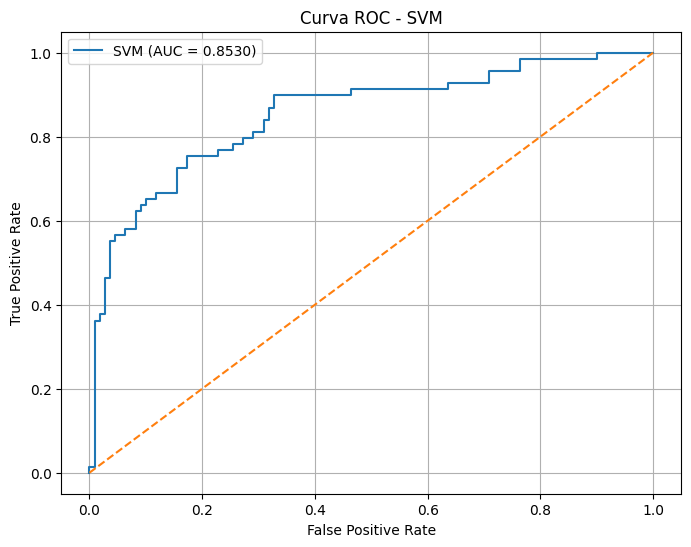

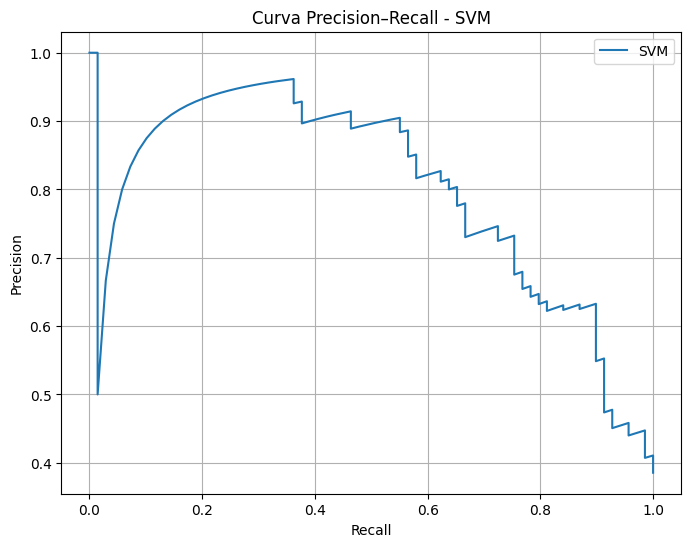

In [ ]:
# Probabilidades previstas pelo modelo SVM
y_scores = best_models['SVM'].decision_function(x_test)

#  CURVA ROC - SVM

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM")
plt.legend()
plt.grid(True)
plt.show()

#  CURVA PRECISION–RECALL - SVM

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="SVM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall - SVM")
plt.legend()
plt.grid(True)
plt.show()

-  XGBoost

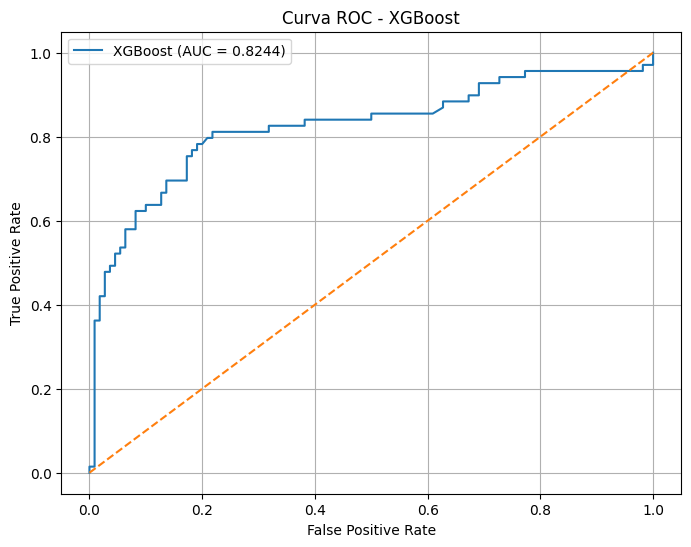

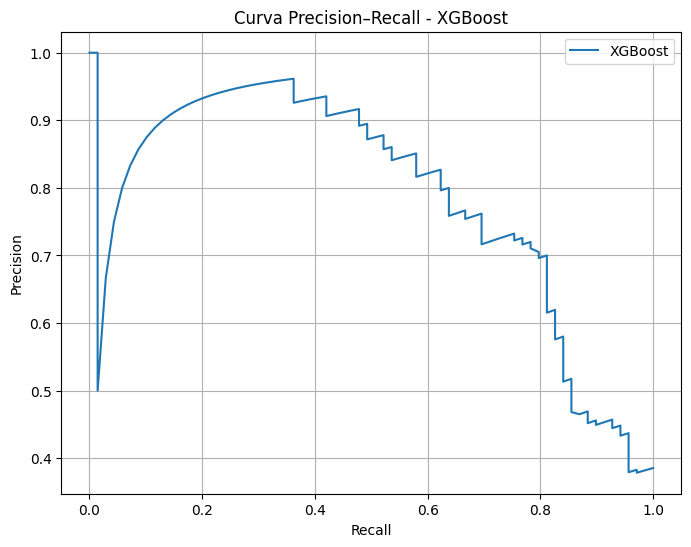

In [ ]:
#  Probabilidades previstas pelo modelo XGBoost
y_proba = best_models['XGBoost'].predict_proba(x_test)[:, 1]

#  CURVA ROC

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

#  CURVA PRECISION–RECALL

precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

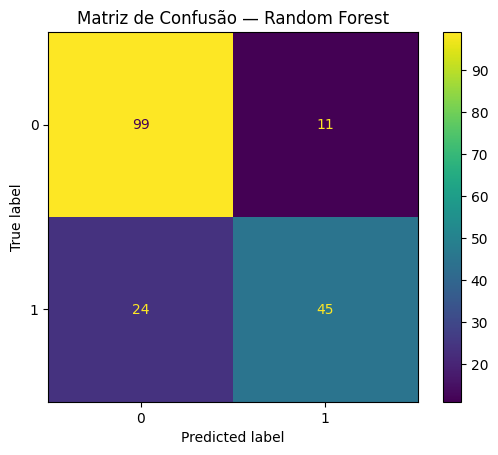

In [ ]:
# MATRIZ DE CONFUSÃO
y_pred = best_models['Random Forest'].predict(x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão — Random Forest")
plt.show()

- Modelo RandomForest


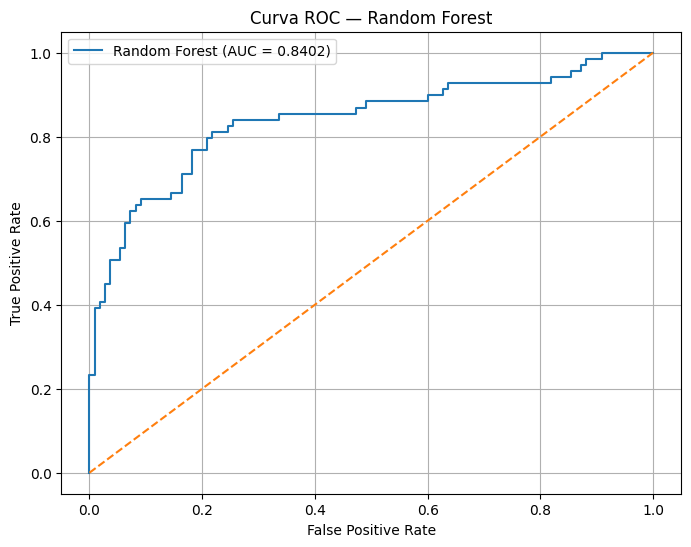

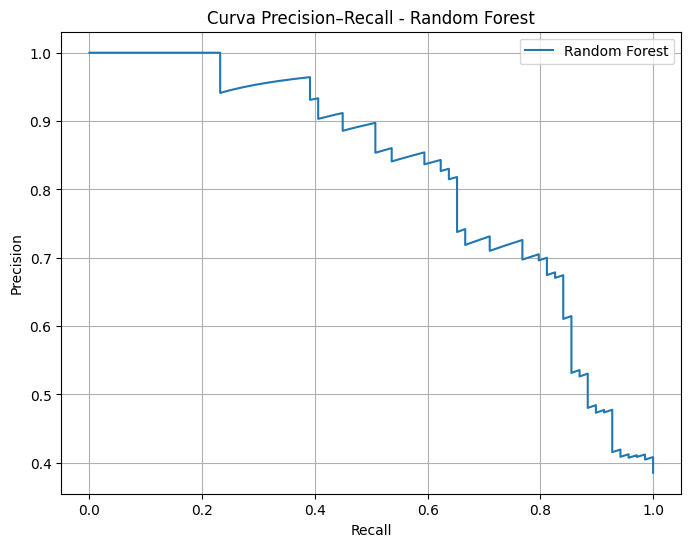

In [ ]:
# Calculate probabilities for Random Forest
y_proba_rf = best_models['Random Forest'].predict_proba(x_test)[:, 1]

# CURVA ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr, tpr) # Assign to a unique variable for clarity

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — Random Forest")
plt.legend()
plt.grid(True)
plt.show()

#  CURVA PRECISION–RECALL
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

# Tabela comparativa com as métricas dos três modelos

In [ ]:
acc_svm = evaluation_metrics['SVM']['accuracy']
f1_svm = evaluation_metrics['SVM']['f1_score']
auc_svm = evaluation_metrics['SVM']['roc_auc']
prec_svm = evaluation_metrics['SVM']['precision']
rec_svm = evaluation_metrics['SVM']['recall']

acc_rf = evaluation_metrics['Random Forest']['accuracy']
f1_rf = evaluation_metrics['Random Forest']['f1_score']
auc_rf = evaluation_metrics['Random Forest']['roc_auc']
prec_rf = evaluation_metrics['Random Forest']['precision']
rec_rf = evaluation_metrics['Random Forest']['recall']

acc_xgb = evaluation_metrics['XGBoost']['accuracy']
f1_xgb = evaluation_metrics['XGBoost']['f1_score']
auc_xgb = evaluation_metrics['XGBoost']['roc_auc']
prec_xgb = evaluation_metrics['XGBoost']['precision']
rec_xgb = evaluation_metrics['XGBoost']['recall']

resultados = {
    "Modelo": ["SVM", "Random Forest", "XGBoost"],
    "Acurácia": [acc_svm, acc_rf, acc_xgb],
    "F1-score": [f1_svm, f1_rf, f1_xgb],
    "ROC-AUC": [auc_svm, auc_rf, auc_xgb],
    "Precisão": [prec_svm, prec_rf, prec_xgb],
    "Recall": [rec_svm, rec_rf, rec_xgb],
}

df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,Acurácia,F1-score,ROC-AUC,Precisão,Recall
0,SVM,0.787709,0.707692,0.852964,0.754098,0.666667
1,Random Forest,0.804469,0.720000,0.840184,0.803571,0.652174
2,XGBoost,0.793296,0.704000,0.824440,0.785714,0.637681


# Verificação de overfitting

In [ ]:
# 1. Selecionar as colunas de ROC-AUC de cada DataFrame
df_test_auc = df_resultados[['Modelo', 'ROC-AUC']].rename(
    columns={'ROC-AUC': 'ROC-AUC (Teste)'}
)

df_train_auc = df_treino_resultados[['Modelo', 'ROC-AUC (Treino)']]

# 2. Juntar os DataFrames pela coluna 'Modelo'
df_comparativo_overfitting = pd.merge(df_train_auc, df_test_auc, on='Modelo')

# 3. Adicionar uma coluna de 'Diferença' para ver o overfitting
#    Valores altos aqui indicam que o treino foi muito melhor que o teste.
df_comparativo_overfitting['Diferença (Overfitting)'] = df_comparativo_overfitting['ROC-AUC (Treino)'] - df_comparativo_overfitting['ROC-AUC (Teste)']

# 4. Ordenar pela melhor performance no teste (maior ROC-AUC Teste)
df_comparativo_overfitting = df_comparativo_overfitting.sort_values(by='ROC-AUC (Teste)', ascending=False)

# 5. Exibir a tabela
print("Tabela Comparativa - Verificação de Overfitting (ROC-AUC)")
df_comparativo_overfitting

Tabela Comparativa - Verificação de Overfitting (ROC-AUC)


,Modelo,ROC-AUC (Treino),ROC-AUC (Teste),Diferença (Overfitting)
0,SVM,0.869171,0.852964,0.016206
2,Random Forest,0.964167,0.840184,0.123982
1,XGBoost,0.933240,0.824440,0.108800


# Comparação Final dos Modelos: SVM, Random Forest e XGBoost

## 1. Qual modelo apresentou melhor desempenho?

o modelo SVM (Support Vector Machine) foi o que apresentou o melhor desempenho geral.

O critério principal de avaliação definido no projeto era a métrica ROC-AUC, e o SVM obteve o valor mais alto no conjunto de teste (0.8530).

Apesar do Random Forest ter tido uma leve vantagem em Acurácia (0.8045 vs 0.7877 do SVM), o SVM se saiu melhor na métrica definida como a mais importante.

---

## 2. Algum modelo mostrou sinais de overfitting?

Sim, o XGBoost e o Random Forest apresentaram sinais claros de overfitting.

Para verificar isso, foi comaparada a performance (ROC-AUC) dos modelos nos dados de treino com a performance nos dados de teste:

- O Random Forest teve um ROC-AUC de 0.9640 no treino, mas caiu para 0.8406 no teste (uma diferença de -0.1234).

- O XGBoost foi ainda pior: marcou 0.9553 no treino e caiu para 0.8179 no teste (uma diferença de -0.1374).

- O SVM, por outro lado, foi o que melhor generalizou. Ele teve 0.8692 no treino e 0.8530 no teste, uma diferença muito pequena (-0.0162), o que indica que ele não sofreu de overfitting.

---

## 3. Quais foram as dificuldades no pré-processamento?

As principais dificuldades no pré-processamento foram:

1. **Tratamento de valores faltantes**  
   O dataset Titanic possui colunas com valores ausentes. Impactando diretamente o desempenho dos modelos.

2. **Transformação de Features**  
   O dataset tem dados mistos. Sendo necessária a aplicação de:
   - **OneHotEncoder:** Para transformar as colunas categóricas (pclass, sex, embarked) em formato numérico que o modelo entende.
   - **StandardScaler:** Para escalonar as features numéricas (age, fare, etc.). Isso foi especialmente importante para o SVM, que é sensível à escala dos dados.

3. **Consistência do processo**  
   A maior dificuldade é garantir que todas essas etapas (imputação, encoding, escalonamento) fossem aplicadas de forma idêntica e sem vazamento de dados (data leakage) tanto no conjunto de treino quanto no de teste. Para resolver isso, foi utilizado Pipeline e ColumnTransformer, o que tornou o processo mais robusto e organizado.

---

## Conclusão

- O SVM foi o modelo com melhor desempenho, pois atingiu o maior ROC-AUC (0.8530) no conjunto de teste, que era a métrica principal.

- O Random Forest e o XGBoost apresentaram sinais claros de overfitting, com uma performance muito alta no treino (ROC-AUC > 0.95) que não se generalizou para os dados de teste.

- O SVM foi o modelo mais estável e com menor overfitting, mostrando a performance mais próxima entre treino (0.8692) e teste (0.8530).

- O pré-processamento exigiu atenção ao tratamento de valores ausentes (em Age e Embarked), ao encoding de variáveis categóricas e à padronização (scaling) das numéricas, que era crucial para o SVM.